### Census Income
Predict whether income exceeds $50K/yr based on census data. Also known as "Adult" dataset.

https://archive.ics.uci.edu/ml/datasets/Census+Income

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship',
           'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'label']

In [3]:
train = pd.read_csv('adult.data.txt', header=None, names=columns, sep=',\s', na_values=["?"], engine='python')

In [4]:
test = pd.read_csv('adult.test.txt', header=None, names=columns, skiprows=1, sep=',\s', na_values=["?"], engine='python')

In [5]:
print(train.shape, test.shape)

(32561, 15) (16281, 15)


In [6]:
train.drop(columns='fnlwgt', inplace=True)
test.drop(columns='fnlwgt', inplace=True)

In [7]:
train.dropna(inplace=True)
test.dropna(inplace=True)

### Take logarithm for skewed features

In [8]:
train['capital-gain'] = train['capital-gain'].apply(lambda x: np.log(x + 1))
train['capital-loss'] = train['capital-loss'].apply(lambda x: np.log(x + 1))
test['capital-gain'] = test['capital-gain'].apply(lambda x: np.log(x + 1))
test['capital-loss'] = test['capital-loss'].apply(lambda x: np.log(x + 1))

### Scaling

In [9]:
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

train[numerical] = scaler.fit_transform(train[numerical])
test[numerical] = scaler.transform(test[numerical])

C:\Anaconda2\envs\dva\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [10]:
train.label = train.label.map({'<=50K':0, '>50K':1})
test.label = test.label.apply(lambda l:l.strip('.')).map({'<=50K':0, '>50K':1})

In [11]:
y_train = train.label.values
X_train = train.drop(columns='label')

y_test = test.label.values
X_test = test.drop(columns='label')

In [12]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

In [13]:
print(X_train.shape, X_test.shape)

(30162, 103) (15060, 102)


In [14]:
X_test = X_test.T.reindex(X_train.columns).T.fillna(0)
print(X_train.shape, X_test.shape)

(30162, 103) (15060, 103)


### Decision Tree

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, fbeta_score, roc_auc_score, \
                            roc_curve, auc, scorer, classification_report, recall_score, make_scorer
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_score, cross_val_predict, learning_curve

In [16]:
model = DecisionTreeClassifier(random_state=1)
model.fit(X_train, y_train)
pred = model.predict(X_test)
print(accuracy_score(y_test, pred))

0.8134794156706507


In [17]:
parameters = {'max_depth':range(2, 20), 'criterion':('gini', 'entropy')}
model = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid=parameters, n_jobs=-1, cv=5, scoring='roc_auc')
model.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': range(2, 20), 'criterion': ('gini', 'entropy')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [18]:
model.best_params_

{'criterion': 'entropy', 'max_depth': 8}

In [19]:
model_dt = DecisionTreeClassifier(random_state=1, criterion='entropy', max_depth=8)
model_dt.fit(X_train, y_train)
pred = model_dt.predict(X_test)
print(accuracy_score(y_test, pred))

0.849667994687915


In [20]:
def plot_learning_curve(model, X, y, n, modelname, cv=5):    
    
    train_sizes, train_scores, validation_scores = learning_curve(model, 
                                                                  X, 
                                                                  y, 
                                                                  train_sizes=np.linspace(0.01, 1.0, n), 
                                                                  cv=cv, 
                                                                  scoring='accuracy', 
                                                                  n_jobs=-1)

    train_mean = np.mean(train_scores, axis=1)
    validation_mean = np.mean(validation_scores, axis=1)

    # Draw lines
    plt.figure(figsize=(12, 8))
    plt.plot(train_sizes, train_mean, '--',  label="Training score")
    plt.plot(train_sizes, validation_mean, label="Cross-validation score")

    # Create plot
    plt.title("Learning Curve--" + modelname)
    plt.xlabel("Training Set Size")
    plt.ylabel("Accuracy Score")
    plt.legend(loc="best")
    plt.tight_layout()
    

def plot_roc_curve(model, train, test, modelname):
    
    preds_train = model.predict_proba(train)[:,1]
    fpr_train, tpr_train, threshold_train = roc_curve(y_train, preds_train)
    roc_auc_train = auc(fpr_train, tpr_train)
    
    preds_test = model.predict_proba(test)[:,1]
    fpr_test, tpr_test, threshold_test = roc_curve(y_test, preds_test)
    roc_auc_test = auc(fpr_test, tpr_test)

    plt.figure(figsize=(10, 10))
    plt.title('ROC Curve--' + modelname)
    plt.plot(fpr_train, tpr_train, label = 'Train AUC = %0.2f' % roc_auc_train)
    plt.plot(fpr_test, tpr_test, label = 'Test AUC = %0.2f' % roc_auc_test)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    
    
def auc_diff(model, train, test):
    return (roc_auc_score(y_train, model.predict_proba(train)[:,1]),
            roc_auc_score(y_test, model.predict_proba(test)[:,1]))

def print_results(model, test, pred, modelname):
    print('Results for', modelname)
    print('\nAUC for train vs AUC for test:')
    print(auc_diff(model, X_train, X_test))
    print('\nF.5 score:\n', fbeta_score(y_test, pred, beta=0.5))
    print('\nConfusion Matrix:\n', confusion_matrix(y_test, pred))
    print('\nClassification Report:\n', classification_report(y_test, pred))

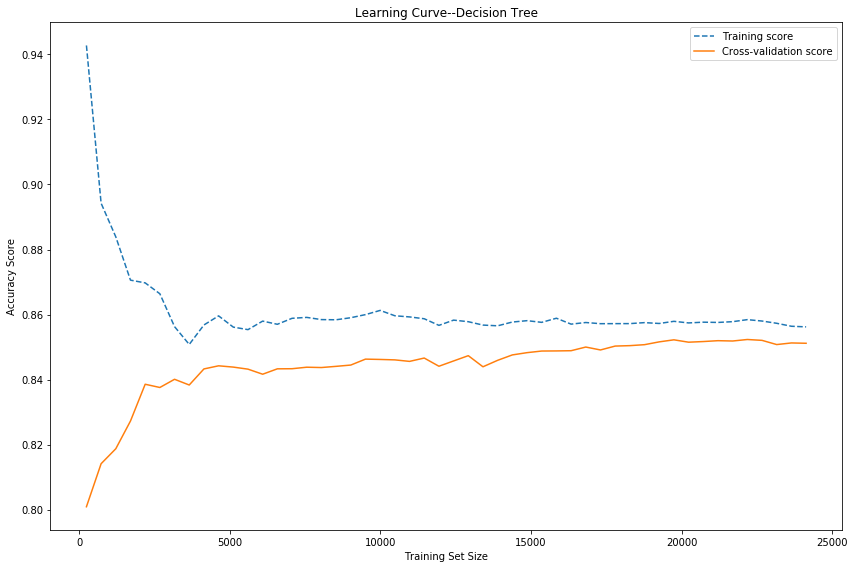

In [21]:
plot_learning_curve(model_dt, X_train, y_train, 50, "Decision Tree")

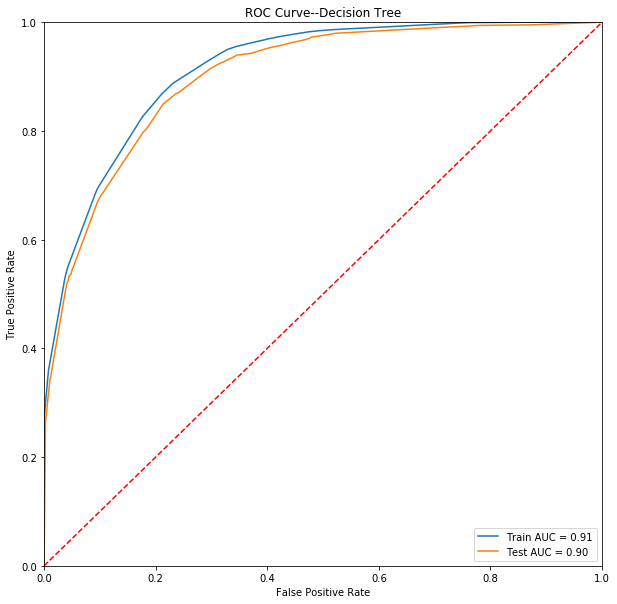

In [22]:
plot_roc_curve(model_dt, X_train, X_test, 'Decision Tree')

In [23]:
print_results(model_dt, y_test, pred, 'Decision Tree')

Results for Decision Tree

AUC for train vs AUC for test:
(0.9137298926111785, 0.8998310691853826)

F.5 score:
 0.7172782432822885

Confusion Matrix:
 [[10810   550]
 [ 1714  1986]]

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.95      0.91     11360
           1       0.78      0.54      0.64      3700

   micro avg       0.85      0.85      0.85     15060
   macro avg       0.82      0.74      0.77     15060
weighted avg       0.84      0.85      0.84     15060



### Boosting

In [24]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

In [25]:
model = GradientBoostingClassifier(random_state=1)
model.fit(X_train, y_train)
pred = model.predict(X_test)
print(accuracy_score(y_test, pred))

0.8653386454183267


In [26]:
model_gbc = GradientBoostingClassifier(n_estimators=60, max_depth=6, learning_rate=0.1, random_state=1)
model_gbc.fit(X_train, y_train)
pred = model_gbc.predict(X_test)
print(accuracy_score(y_test, pred))

0.8695883134130146


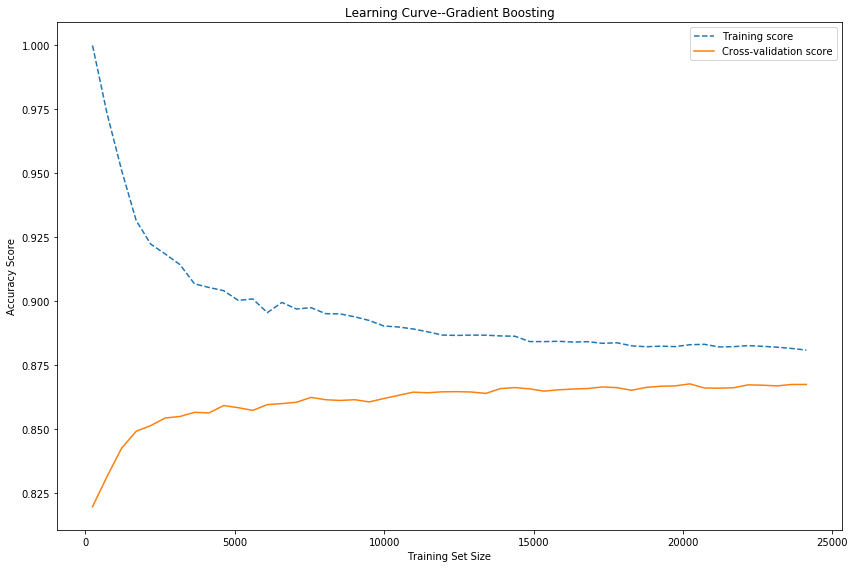

In [27]:
plot_learning_curve(model_gbc, X_train, y_train, 50, "Gradient Boosting")

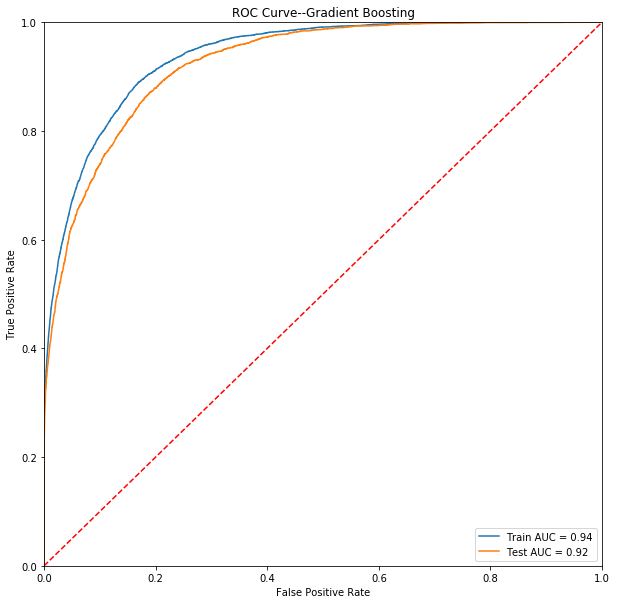

In [28]:
plot_roc_curve(model_gbc, X_train, X_test, 'Gradient Boosting')

In [29]:
print_results(model_gbc, y_test, pred, 'Gradient Boosting')

Results for Gradient Boosting

AUC for train vs AUC for test:
(0.9385512197130689, 0.9243811738675294)

F.5 score:
 0.7523235367997991

Confusion Matrix:
 [[10700   660]
 [ 1304  2396]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.94      0.92     11360
           1       0.78      0.65      0.71      3700

   micro avg       0.87      0.87      0.87     15060
   macro avg       0.84      0.79      0.81     15060
weighted avg       0.86      0.87      0.87     15060



### SVM

In [30]:
from sklearn.svm import SVC

In [31]:
model_svc_lin = SVC(kernel='linear', random_state=1, probability=True)
model_svc_lin.fit(X_train, y_train)
pred = model_svc_lin.predict(X_test)
print(accuracy_score(y_test, pred))

0.8409030544488711


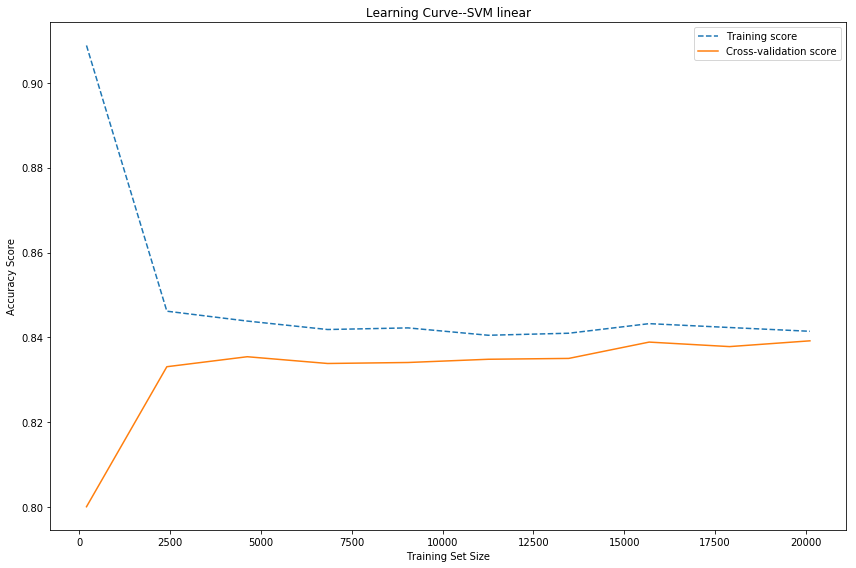

In [32]:
plot_learning_curve(model_svc_lin, X_train, y_train, 10, "SVM linear", cv=3)

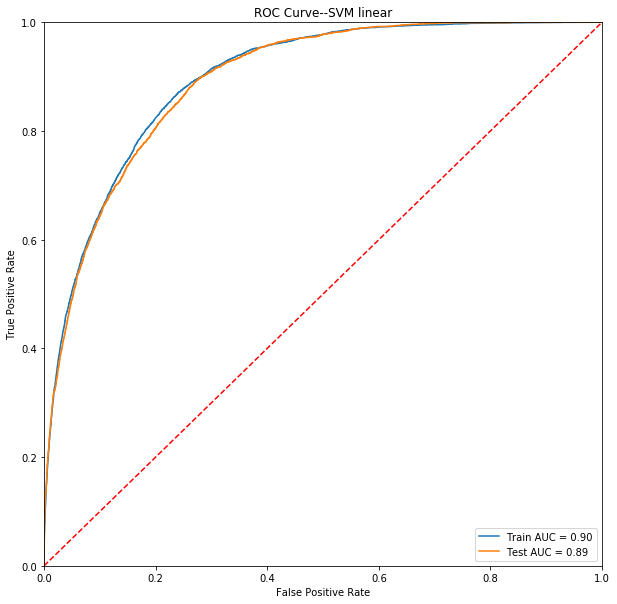

In [33]:
plot_roc_curve(model_svc_lin, X_train, X_test, 'SVM linear')

In [34]:
print_results(model_svc_lin, y_test, pred, 'SVM linear')

Results for SVM linear

AUC for train vs AUC for test:
(0.8966345024328601, 0.8935685549105444)

F.5 score:
 0.6858151476251605

Confusion Matrix:
 [[10527   833]
 [ 1563  2137]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.93      0.90     11360
           1       0.72      0.58      0.64      3700

   micro avg       0.84      0.84      0.84     15060
   macro avg       0.80      0.75      0.77     15060
weighted avg       0.83      0.84      0.83     15060



In [35]:
model_svc_rbf = SVC(kernel='rbf', random_state=1, probability=True, gamma='auto')
model_svc_rbf.fit(X_train, y_train)
pred = model_svc_rbf.predict(X_test)
print(accuracy_score(y_test, pred))

0.8399734395750332


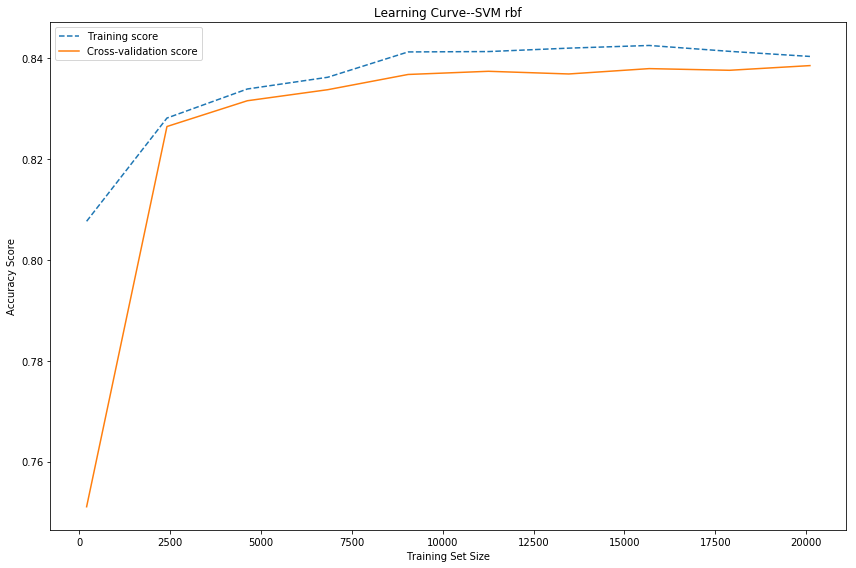

In [36]:
plot_learning_curve(model_svc_rbf, X_train, y_train, 10, "SVM rbf", cv=3)

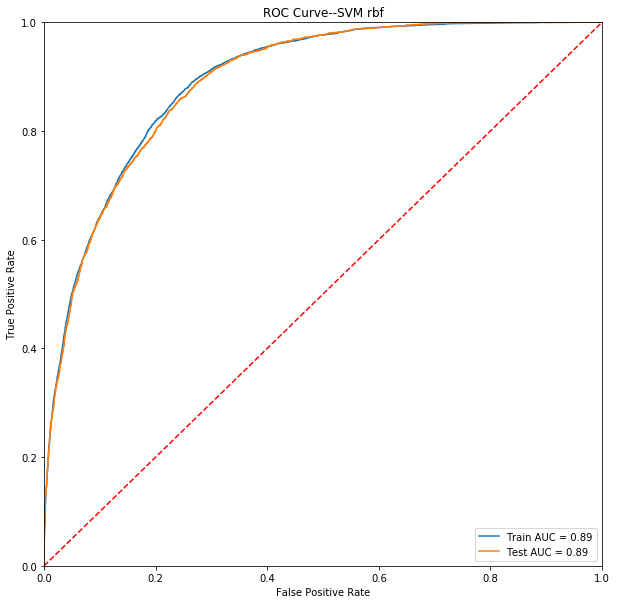

In [37]:
plot_roc_curve(model_svc_rbf, X_train, X_test, 'SVM rbf')

In [38]:
print_results(model_svc_rbf, y_test, pred, 'SVM rbf')

Results for SVM rbf

AUC for train vs AUC for test:
(0.8940924330665401, 0.8917851874762087)

F.5 score:
 0.6858171154358838

Confusion Matrix:
 [[10592   768]
 [ 1642  2058]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.93      0.90     11360
           1       0.73      0.56      0.63      3700

   micro avg       0.84      0.84      0.84     15060
   macro avg       0.80      0.74      0.76     15060
weighted avg       0.83      0.84      0.83     15060



In [39]:
from sklearn.neighbors import KNeighborsClassifier

In [40]:
def knn_test(K):
    scores = []
    aucs = []
    fs = []
    for k in K:
        knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
        knn.fit(X_train, y_train)
        pred = knn.predict(X_test)
        score = accuracy_score(y_test, pred)
        auc = roc_auc_score(y_test, knn.predict_proba(X_test)[:,1])
        f = fbeta_score(y_test, pred, beta=0.5)
        scores.append(score)
        aucs.append(auc)
        fs.append(f)
    return scores, aucs, fs

In [41]:
K_range = np.arange(1, 20, 2)

scores, aucs, fs = knn_test(K_range)

Text(0.5, 1.0, 'KNN performance vs K')

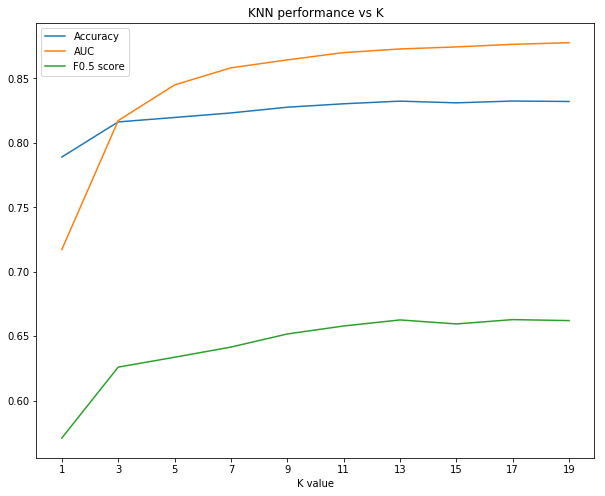

In [42]:
plt.figure(figsize=(10, 8))
plt.plot(K_range, scores, label='Accuracy')
plt.plot(K_range, aucs, label='AUC')
plt.plot(K_range, fs, label='F0.5 score')
plt.legend()
plt.xlabel('K value')
plt.xticks(ticks=K_range)
plt.title('KNN performance vs K')

In [43]:
model_knn = KNeighborsClassifier(n_neighbors=19, n_jobs=-1)
model_knn.fit(X_train, y_train)
pred = model_knn.predict(X_test)
print(accuracy_score(y_test, pred))

0.8320717131474104


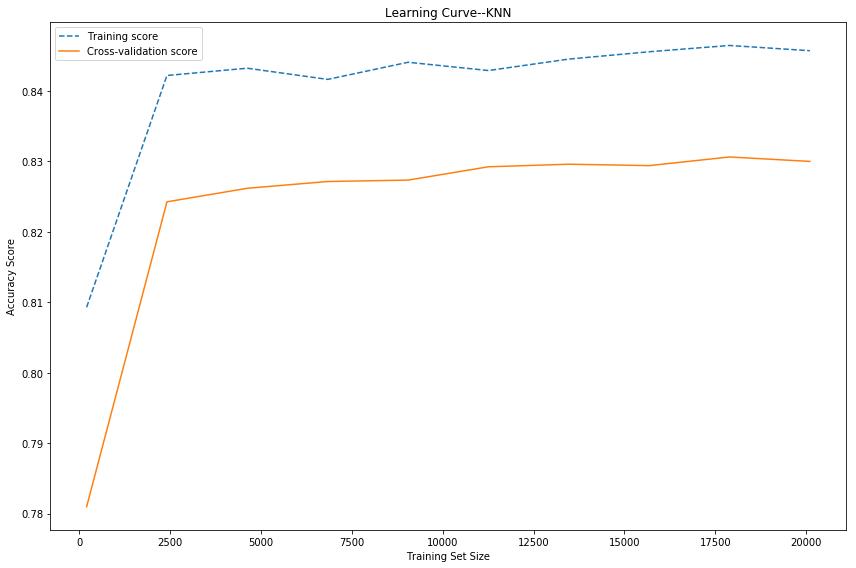

In [44]:
plot_learning_curve(model_knn, X_train, y_train, 10, 'KNN', cv=3)

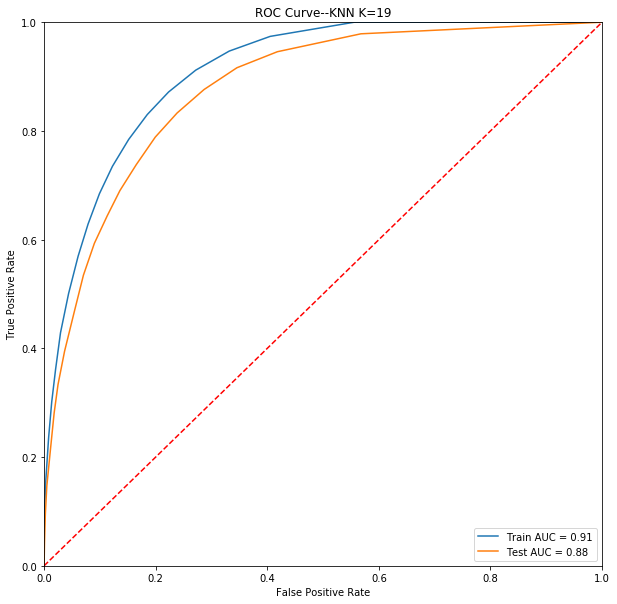

In [45]:
plot_roc_curve(model_knn, X_train, X_test, 'KNN K=19')

In [46]:
print_results(model_knn, y_test, pred, 'KNN K=19')

Results for KNN K=19

AUC for train vs AUC for test:
(0.9090722581237498, 0.8776699181575942)

F.5 score:
 0.662101833976834

Confusion Matrix:
 [[10336  1024]
 [ 1505  2195]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.91      0.89     11360
           1       0.68      0.59      0.63      3700

   micro avg       0.83      0.83      0.83     15060
   macro avg       0.78      0.75      0.76     15060
weighted avg       0.83      0.83      0.83     15060



### MLP

In [47]:
from sklearn.neural_network import MLPClassifier

In [48]:
model_mlp = MLPClassifier(random_state=1, early_stopping=True, hidden_layer_sizes=(500,500,50,10), verbose=10, 
                          max_iter=500, solver='adam', tol=0.000000001, validation_fraction=0.2)

model_mlp.fit(X_train, y_train)

Iteration 1, loss = 0.37819751
Validation score: 0.842698
Iteration 2, loss = 0.33574271
Validation score: 0.840709
Iteration 3, loss = 0.32975160
Validation score: 0.840875
Iteration 4, loss = 0.32297780
Validation score: 0.839881
Iteration 5, loss = 0.31810648
Validation score: 0.836897
Iteration 6, loss = 0.31143796
Validation score: 0.838886
Iteration 7, loss = 0.30626865
Validation score: 0.838389
Iteration 8, loss = 0.30078990
Validation score: 0.837560
Iteration 9, loss = 0.29346695
Validation score: 0.833748
Iteration 10, loss = 0.28855950
Validation score: 0.832422
Iteration 11, loss = 0.28362671
Validation score: 0.831593
Iteration 12, loss = 0.27681621
Validation score: 0.839052
Validation score did not improve more than tol=0.000000 for 10 consecutive epochs. Stopping.


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(500, 500, 50, 10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='adam', tol=1e-09,
       validation_fraction=0.2, verbose=10, warm_start=False)

In [49]:
pred = model_mlp.predict(X_test)
print(accuracy_score(y_test, pred))

0.8402390438247012


### Try PCA then MLP again

In [50]:
from sklearn.decomposition import PCA

In [51]:
# print cumulated explained_variance_ratio
def print_var(pca):
    print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))

pca = PCA(n_components=50)
X_train_reduced = pca.fit_transform(X_train)
print_var(pca)

[19.15 26.97 33.81 39.56 44.36 48.98 53.11 56.37 59.39 62.06 64.69 67.18
 69.41 71.46 73.35 75.15 76.77 78.3  79.57 80.77 81.89 82.93 83.96 84.97
 85.93 86.83 87.65 88.44 89.21 89.96 90.69 91.42 92.12 92.81 93.45 94.04
 94.52 94.96 95.36 95.75 96.11 96.43 96.74 97.04 97.32 97.6  97.85 98.04
 98.22 98.35]


In [52]:
X_test_reduced = pca.transform(X_test)

In [53]:
print(X_train_reduced.shape, X_test_reduced.shape)

(30162, 50) (15060, 50)


In [54]:
model_mlp = MLPClassifier(random_state=1, early_stopping=True, hidden_layer_sizes=(100,), verbose=10, 
                          max_iter=200, solver='adam', tol=0.000000001, validation_fraction=0.05)

model_mlp.fit(X_train_reduced, y_train)

Iteration 1, loss = 0.48699608
Validation score: 0.840292
Iteration 2, loss = 0.34804720
Validation score: 0.834327
Iteration 3, loss = 0.33605064
Validation score: 0.838304
Iteration 4, loss = 0.33223097
Validation score: 0.842280
Iteration 5, loss = 0.33006615
Validation score: 0.842280
Iteration 6, loss = 0.32839846
Validation score: 0.845593
Iteration 7, loss = 0.32699997
Validation score: 0.846256
Iteration 8, loss = 0.32529649
Validation score: 0.847581
Iteration 9, loss = 0.32385871
Validation score: 0.843605
Iteration 10, loss = 0.32249313
Validation score: 0.844268
Iteration 11, loss = 0.32130822
Validation score: 0.846256
Iteration 12, loss = 0.31990952
Validation score: 0.841617
Iteration 13, loss = 0.31857816
Validation score: 0.845593
Iteration 14, loss = 0.31741794
Validation score: 0.845593
Iteration 15, loss = 0.31605896
Validation score: 0.844930
Iteration 16, loss = 0.31495163
Validation score: 0.848244
Iteration 17, loss = 0.31362551
Validation score: 0.846256
Iterat

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='adam', tol=1e-09,
       validation_fraction=0.05, verbose=10, warm_start=False)

In [55]:
pred = model_mlp.predict(X_test_reduced)
print(accuracy_score(y_test, pred))

0.8457503320053121


Text(0, 0.5, 'Validation loss')

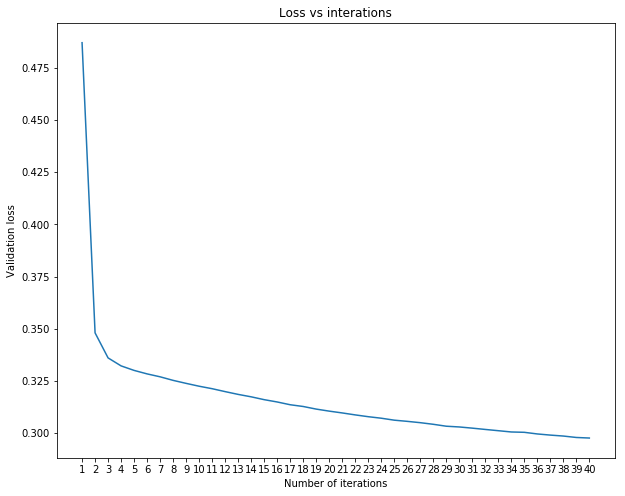

In [56]:
param_range = np.arange(1, model_mlp.n_iter_+1)
plt.figure(figsize=(10, 8))
plt.plot(param_range, model_mlp.loss_curve_)
plt.title('Loss vs interations')
plt.xticks(param_range)
plt.xlabel('Number of iterations')
plt.ylabel('Validation loss')

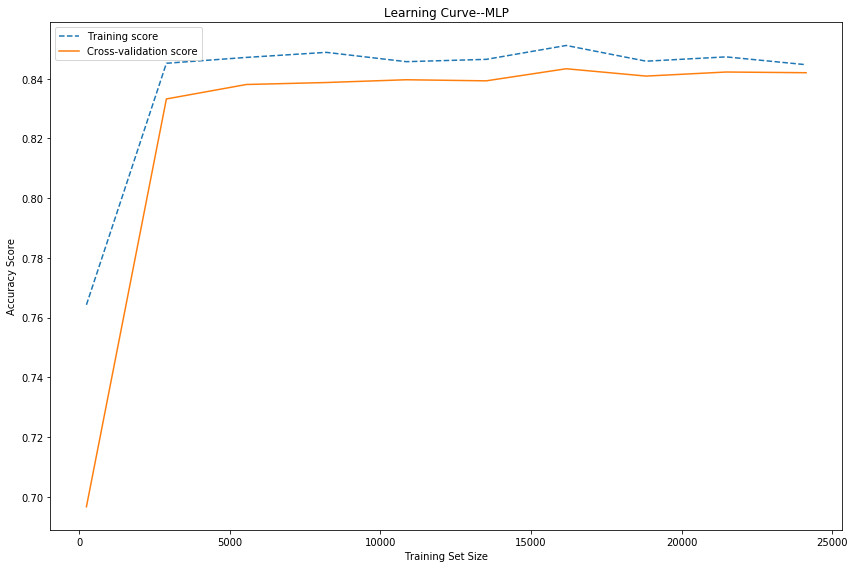

In [57]:
plot_learning_curve(model_mlp, X_train_reduced, y_train, 10, 'MLP', cv=5)

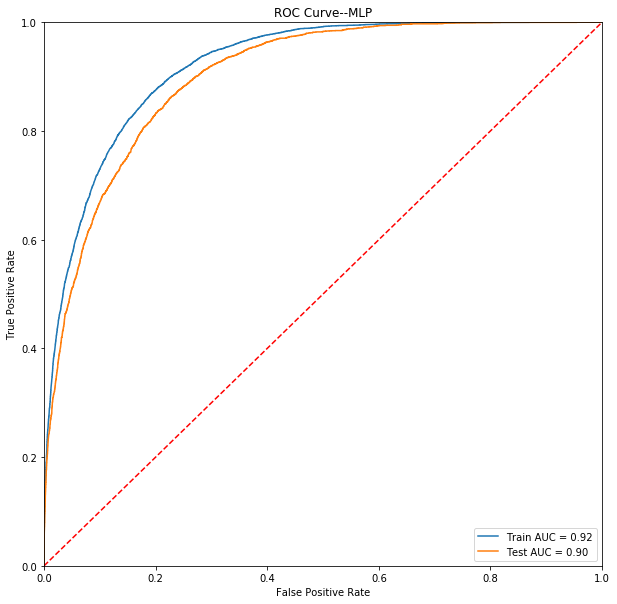

In [58]:
plot_roc_curve(model_mlp, X_train_reduced, X_test_reduced, 'MLP')

In [59]:
print('\nAUC for train vs AUC for test:')
print(auc_diff(model_mlp, X_train_reduced, X_test_reduced))
print('\nF.5 score:\n', fbeta_score(y_test, pred, beta=0.5))
print('\nConfusion Matrix:\n', confusion_matrix(y_test, pred))
print('\nClassification Report:\n', classification_report(y_test, pred))


AUC for train vs AUC for test:
(0.9200079345634513, 0.9008195779406167)

F.5 score:
 0.6938352826510723

Confusion Matrix:
 [[10459   901]
 [ 1422  2278]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.92      0.90     11360
           1       0.72      0.62      0.66      3700

   micro avg       0.85      0.85      0.85     15060
   macro avg       0.80      0.77      0.78     15060
weighted avg       0.84      0.85      0.84     15060



### Gradient boosting is the winner in terms of AUC, F.5 score and overall accuracy.